In [1]:
import sys, os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
import math

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(0)
MAX_LEN = 64

In [2]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, AutoModel


class VecModel(nn.Module):
    def __init__(self, model_name, size, has_top=True):
        super(VecModel, self).__init__()
        conf = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_config(conf)
        
        self.has_top = has_top
        
        if self.has_top:
            self.bn = nn.BatchNorm1d(size)
            self.top = nn.Linear(size, size)

    def forward(self, ids, mask):
        out = self.backbone(ids, mask)[0]
        out = (out[:, 1:MAX_LEN//2, :]*mask[:, 1:MAX_LEN//2, None]).mean(axis=1)
        
        if self.has_top:
            out = self.top(self.bn(out))
        
        return F.normalize(out)

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path, map_location='cpu'))

In [3]:
corr_df = pd.read_csv("data/correlations.csv")

corr_df["content_ids"] = corr_df["content_ids"].apply(lambda x: x.split())

corr_df = corr_df.explode('content_ids').reset_index(drop=True)
corr_df

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d
1,t_00004da3a1b2,c_376c5a8eb028
2,t_00004da3a1b2,c_5bc0e1e2cba0
3,t_00004da3a1b2,c_76231f9d0b5e
4,t_00068291e9a4,c_639ea2ef9c95
...,...,...
279914,t_fff9e5407d13,c_d64037a72376
279915,t_fffbe1d5d43c,c_46f852a49c08
279916,t_fffbe1d5d43c,c_6659207b25d5
279917,t_fffe14f1be1e,c_cece166bad6a


In [4]:
topic_df = pd.read_csv("data/topics.csv")
topic_df["title"] = topic_df["title"].fillna("")

title_map = topic_df.set_index("id")["title"].to_dict()
parent_map = topic_df.set_index("id")["parent"].to_dict()

topic_df = topic_df[topic_df["has_content"]].reset_index(drop=True)
print(topic_df.shape)

topic_df["parent_title"] = topic_df["parent"].apply(lambda x: title_map.get(x, ""))
print(topic_df.shape)

topic_df["grandpa"] = topic_df["parent"].apply(lambda x: parent_map.get(x))
topic_df["grandpa_title"] = topic_df["grandpa"].apply(lambda x: title_map.get(x, ""))
print(topic_df.shape)

topic_df["ggrandpa"] = topic_df["grandpa"].apply(lambda x: parent_map.get(x))
topic_df["ggrandpa_title"] = topic_df["ggrandpa"].apply(lambda x: title_map.get(x, ""))
print(topic_df.shape)

topic_df.head()

(61517, 9)
(61517, 10)
(61517, 12)
(61517, 14)


,id,title,description,channel,category,level,language,parent,has_content,parent_title,grandpa,grandpa_title,ggrandpa,ggrandpa_title
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,Открития и проекти,t_c85886762db7,Физика,t_27a0a3c7ee9a,Наука
1,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,Álgebra: funções,t_461c9a8dd863,9º Ano,t_a6420bcff569,Matemática por ano (Alinhada à BNCC)
2,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,Flow Charts: Logical Thinking?,t_acbbd893e6af,Engineering,t_9c5f09334d83,MIT Blossoms
3,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Показателни и логаритмични функции,t_5f4cc8e02423,Алгебра (цялото съдържание),t_afd8db5e4f44,Математика
4,t_0008768bdee6,100 સુધીનો સરવાળો,37 અને 49 જેવી બે-અંકની સંખ્યાઓ ઉમેરતા શીખો.,5223e0,supplemental,4,gu,t_0da7a331d666,True,100 સુધીના સરવાળા અને બાદબાકી,t_d20fc01fdf38,પ્રારંભિક ગણિત,t_38bca5075c51,ધોરણ ૩


In [5]:
from sklearn.model_selection import KFold


N_FOLDS = 3

splits = KFold(N_FOLDS, shuffle=True, random_state=0).split(topic_df, topic_df["has_content"])

topic_df["fold"] = 0

for f, (train_ind, val_ind) in enumerate(splits):
    topic_df.loc[val_ind, "fold"] = f

topic_df["fold"].value_counts()

0    20506
1    20506
2    20505
Name: fold, dtype: int64

In [6]:
topic_df.loc[(topic_df["category"] == "source") | (topic_df["fold"] > 0), "fold"] = 1
topic_df["fold"].value_counts()

1    53269
0     8248
Name: fold, dtype: int64

In [7]:
le_topic = LabelEncoder()
topic_df["t"] = topic_df["title"].fillna("") + " | " + topic_df["description"].fillna("")
topic_df["label"] = le_topic.fit_transform(topic_df["t"])

len(le_topic.classes_)

41024

In [8]:
content_df = pd.read_csv("data/content.csv")
content_df.loc[content_df["title"] == content_df["description"], "description"] = None
content_df["description"].fillna(content_df["text"].fillna("").apply(lambda x: x[:256]), inplace=True)
content_df["t"] = content_df["title"].fillna("") + " | " + content_df["kind"].fillna("") + " | " + content_df["description"].fillna("")

print(content_df.shape)
content_df.head()

(154047, 9)


,id,title,description,kind,text,language,copyright_holder,license,t
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN,"Sumar números de varios dígitos: 48,029+233,93..."
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN,Trovare i fattori di un numero | video | Sal t...
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN,Sumar curvas de demanda | video | Cómo añadir ...
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação | document | Neste vídeo v...
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,Estándares Comunes del Estado de Nueva York\n\...,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf | document | ...


In [9]:
def extract_number(x, is_subtopic=False):
    chapter, rest = x.split(":", 1)
    
    if is_subtopic:
        chapter = chapter.split(".", 1)[0]
        x = f"{chapter}:{rest}"
    chapter = int(chapter)

    return chapter, x


def extract_chapters(df, is_subtopic):
    titles = df["title"].fillna("").values
    
    chapters = np.zeros(len(titles))
    new_titles = np.array(titles)
    
    for i, title in enumerate(titles):
        try:
            chapters[i], new_titles[i] = extract_number(title, is_subtopic)
        except:
            pass
        
    df["chapter"], df["title"] = chapters, new_titles
    df["chapter"] = df["chapter"].astype(int)
    
    df.loc[df["chapter"] == 0, "chapter"] = None
    return df
    
topic_df = extract_chapters(topic_df, False)
content_df = extract_chapters(content_df, True)

topic_df["chapter"].isnull().mean(), content_df["chapter"].isnull().mean()

(0.9733569582391859, 0.9165319675164073)

In [10]:
TEST_FOLD = 0

topic_df["t"] = topic_df["title"] + " @ " + topic_df["parent_title"] + " @ " + topic_df["grandpa_title"] + " @ " + topic_df["ggrandpa_title"] + " | " + topic_df["description"].fillna("")

topic_df_test = topic_df[topic_df["fold"] == TEST_FOLD].reset_index(drop=True)
topic_df_train = topic_df[topic_df["fold"] != TEST_FOLD].reset_index(drop=True)

topic_df_train.shape, topic_df_test.shape

((53269, 18), (8248, 18))

In [11]:
train_contents = corr_df.merge(topic_df_train[["id"]], left_on="topic_id", right_on="id")[["content_ids"]].drop_duplicates()
train_contents.rename(columns={"content_ids": "id"}, inplace=True)
train_contents["is_train"] = True
train_contents.shape

(141107, 2)

In [12]:
content_df = content_df.merge(train_contents, on="id", how="left")
content_df["is_train"].fillna(False, inplace=True)
content_df["is_train"].mean()

0.9159996624406836

In [13]:
#corr_df["label"] = le_topic.transform(corr_df["topic_id"])
corr_df = corr_df.merge(topic_df[["id", "label"]].rename(columns={"id": "topic_id"}), on="topic_id")


content_labels = corr_df.groupby("content_ids").agg({"label": list}).reset_index()
content_labels = content_labels.rename(columns={"content_ids": "id"})
content_labels["label"] = content_labels["label"].apply(lambda x: list(set(x)))

topic_df_train["label"] = topic_df_train["label"].apply(lambda x: [x])
topic_df_test["label"] = topic_df_test["label"].apply(lambda x: [x])

content_labels

,id,label
0,c_00002381196d,"[27817, 27750]"
1,c_000087304a9e,"[13283, 13284]"
2,c_0000ad142ddb,[11785]
3,c_0000c03adc8d,[23664]
4,c_00016694ea2a,"[21301, 32510]"
...,...,...
154042,c_fffcbdd4de8b,[2312]
154043,c_fffe15a2d069,"[27466, 27467, 16294]"
154044,c_fffed7b0d13a,"[22032, 22033, 22034]"
154045,c_ffff04ba7ac7,[3455]


In [14]:
print(content_df.shape)

content_df = content_df.merge(content_labels, on="id") #, how="left")
content_df

(154047, 11)


,id,title,description,kind,text,language,copyright_holder,license,t,chapter,is_train,label
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN,"Sumar números de varios dígitos: 48,029+233,93...",NaN,True,"[27817, 27750]"
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN,Trovare i fattori di un numero | video | Sal t...,NaN,True,"[13283, 13284]"
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN,Sumar curvas de demanda | video | Cómo añadir ...,NaN,True,[11785]
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,Nado de aproximação | document | Neste vídeo v...,NaN,True,[23664]
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,Estándares Comunes del Estado de Nueva York\n\...,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,geometry-m3-topic-a-overview.pdf | document | ...,NaN,True,"[21301, 32510]"
...,...,...,...,...,...,...,...,...,...,...,...,...
154042,c_fffcbdd4de8b,2: Diffusion,What will eventually happen to these dyes?\n\n...,html5,What will eventually happen to these dyes?\n\n...,en,CSU and Merlot,CC BY-NC-SA,2. 12: Diffusion | html5 | What will eventuall...,2.0,True,[2312]
154043,c_fffe15a2d069,Sommare facendo gruppi da 10,Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n,video,NaN,it,NaN,NaN,Sommare facendo gruppi da 10 | video | Sal som...,NaN,True,"[27466, 27467, 16294]"
154044,c_fffed7b0d13a,Introdução à subtração,Sal fala sobre o que significa subtrair. Os ex...,video,NaN,pt,NaN,NaN,Introdução à subtração | video | Sal fala sobr...,NaN,True,"[22032, 22033, 22034]"
154045,c_ffff04ba7ac7,SA of a Cone,,video,NaN,en,NaN,NaN,SA of a Cone | video |,NaN,True,[3455]


In [15]:
MODEL_NAME = "xlm-roberta-large"

roberta_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [16]:
MODEL_NAME = "bert-base-multilingual-uncased"

bert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [17]:
NW = 8
BS = 64

class LECRDataset(Dataset):
    def __init__(self, df, max_len=512):
        self.df = df.reset_index(drop=True)
        self.max_len = max_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        encoding = roberta_tokenizer(str(row.t), padding='max_length', 
                                  truncation=True, max_length=self.max_len)

        encoding = {key: torch.as_tensor(val) for key, val in encoding.items()}

        encoding2 = bert_tokenizer(str(row.t), padding='max_length', 
                              truncation=True, max_length=self.max_len)
        encoding2 = {f"bert_{key}": torch.as_tensor(val) for key, val in encoding2.items()}
        
        encoding.update(encoding2)

        return encoding
    
model_w = [0.25, 0.25, 0.50]

models = [VecModel("bert-base-multilingual-uncased", 768, has_top=False),
          VecModel("xlm-roberta-base", 768, has_top=False), 
          VecModel("xlm-roberta-large", 1024)]
for model in models:
    model.cuda()
    model.eval()

In [18]:
models[0].load("models/vec_model_v36bert.pth")
models[1].load("models/vec_model_v36.pth")
models[2].load("models/vec_model_v35large.pth")

In [19]:
from sklearn.neighbors import NearestNeighbors


def to_vec(models, ds):
    val_loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                             pin_memory=False, drop_last=False)

    tbar = tqdm(val_loader, file=sys.stdout)

    vectors = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            ids, mask = data["input_ids"].cuda(), data["attention_mask"].cuda()
            bert_ids, bert_mask = data["bert_input_ids"].cuda(), data["bert_attention_mask"].cuda()
            
            vec_list = [model_w[0]*models[0](bert_ids, bert_mask)]
            for i in range(1, 3):
                vec_list.append(model_w[i]*models[i](ids, mask))
                

            vec = torch.cat(vec_list, axis=1)
            vectors.append(vec.detach().cpu().numpy())

    V = np.concatenate(vectors)
    
    return V



def get_matches(V_topic, V_content, topic_ids, content_ids, n_neighbors=5):
    
    neighbors_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', n_jobs=-1)
    neighbors_model.fit(V_content)
    dists, indices = neighbors_model.kneighbors(V_topic)
    
    res_df = pd.DataFrame({"topic_id": np.repeat(topic_ids, n_neighbors),
                           'content_id': content_ids[indices.ravel()],
                           'vec_dist': dists.ravel()
                          })
    return res_df


def f2(recall, precision):
    return 5*precision*recall/(4*precision + recall)

def metric(pred_df):
    scores = np.zeros(pred_df.shape[0])

    for i, (gt, pred) in enumerate(zip(pred_df["content_ids"].values, pred_df["pred"].values)):
        hits = 0

        gt, pred = gt.split(), pred.split()

        for l in gt:
            if l in pred:
                hits += 1

        if hits > 0:           
            recall = hits / len(gt)
            precision = hits / len(pred)

            scores[i] = f2(recall, precision)

    return scores.mean()
    

def evaluate(topic_df, content_df):    
    topic_ds = LECRDataset(topic_df, tokenizer, MAX_LEN, aug=False)
    content_ds = LECRDataset(content_df, tokenizer, MAX_LEN, aug=False)


    V_topic = to_vec(model, topic_ds)
    V_content = to_vec(model, content_ds)

    res_df = get_matches(V_topic, V_content, topic_df["id"].values, content_df["id"].values)

    res_df["rank"] = res_df.groupby("topic_id")["vec_dist"].rank(method="first", ascending=True)

    pred_df = res_df.copy() #res_df[(res_df["rank"] == 1) | (res_df["vec_dist"] < 0.1)]
    pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
    pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
    pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

    return metric(pred_df)

In [20]:
topic_ds = LECRDataset(topic_df_test, MAX_LEN)
content_ds = LECRDataset(content_df, MAX_LEN)


V_topic = to_vec(models, topic_ds)
V_content = to_vec(models, content_ds)

100%|███████████████████████████████████████| 2407/2407 [07:35<00:00,  5.28it/s]


In [21]:
res_dfs = []

for lang in topic_df_test["language"].unique():
    topic_ix = np.where(topic_df_test["language"] == lang)[0]
    content_ix = np.where(content_df["language"] == lang)[0]
    
    res_dfs.append(get_matches(V_topic[topic_ix], V_content[content_ix], 
                               topic_df_test["id"].values[topic_ix], content_df["id"].values[content_ix],
                    n_neighbors=20))
res_df = pd.concat(res_dfs)
res_df.shape

(164960, 3)

In [22]:
topic_ds = LECRDataset(topic_df_train, MAX_LEN)

V_topic_train = to_vec(models, topic_ds)

100%|█████████████████████████████████████████| 833/833 [02:38<00:00,  5.26it/s]


<AxesSubplot:>

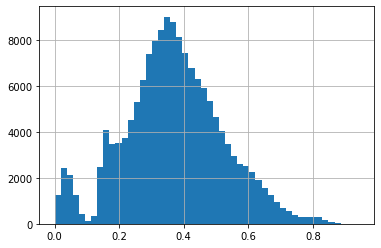

In [23]:
def get_max_train(df, V):
    max_train_scores = np.zeros(df.shape[0])
    matches = np.zeros(df.shape[0])

    for lang in df["language"].unique():
        topic_ix = np.where(topic_df_train["language"] == lang)[0]
        ix = np.where(df["language"] == lang)[0]

        neighbors_model = NearestNeighbors(n_neighbors=1, metric='cosine', n_jobs=4)
        neighbors_model.fit(V_topic_train[topic_ix])
        dists, idx = neighbors_model.kneighbors(V[ix])

        max_train_scores[ix] = dists.ravel()
        matches[ix] = topic_ix[idx.ravel()]  
        
    return max_train_scores, matches


content_max_train_scores, _ = get_max_train(content_df, V_content)
    
content_df["max_train_score"] = content_max_train_scores
content_df["max_train_score"].hist(bins=50)

<AxesSubplot:>

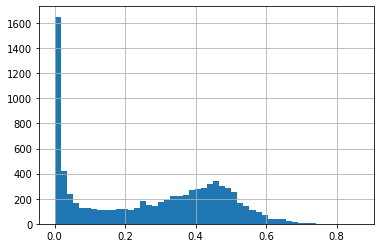

In [24]:
topic_max_train_scores, topic_matches = get_max_train(topic_df_test, V_topic)
    
topic_df_test["max_train_score"] = topic_max_train_scores
topic_df_test["matched_topic"] = topic_df_train["id"].values[topic_matches.astype(int)]

topic_df_test["max_train_score"].hist(bins=50)

In [25]:
second_degree_match_df = topic_df_test.merge(corr_df, left_on="matched_topic", right_on="topic_id")[["id", "content_ids"]]
second_degree_match_df["second_degree"] = True
second_degree_match_df.rename(columns={"id": "topic_id", "content_ids": "content_id"}, inplace=True)
second_degree_match_df.shape

(35780, 3)

In [26]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn


def get_matches(topic_df, content_df):
    tfidf = TfidfVectorizer(analyzer="char", ngram_range=(4, 4), min_df=2)

    tfidf.fit(pd.concat([content_df["t"], topic_df["t"]]))
    print(len(tfidf.vocabulary_), topic_df.shape[0], content_df.shape[0])
    
    topic_df = topic_df[topic_df["fold"] == TEST_FOLD].reset_index(drop=True)
    
    V_topic = tfidf.transform(topic_df["title"] + " " + topic_df["t"])
    V_content = tfidf.transform(content_df["title"] + " " + content_df["t"])

    d = awesome_cossim_topn(V_topic, V_content.T, 20, 0.01, use_threads=True, n_jobs=4)

    non_zeros = d.nonzero()

    name_indices = non_zeros[0]
    gt_indices = non_zeros[1]

    content_ids = content_df["id"].values
    topic_ids = topic_df["id"].values

    left_side = np.empty(gt_indices.size, dtype=object)
    right_side = np.empty(gt_indices.size, dtype=object)
    match_score = np.zeros(gt_indices.size)

    for index in range(gt_indices.size):
        left_side[index] = topic_ids[name_indices[index]]
        right_side[index] = content_ids[gt_indices[index]]
        match_score[index] = d.data[index]

    res_df = pd.DataFrame({"topic_id": left_side,
                           'content_id': right_side,
                           'match_score': match_score
                          })
    return res_df


res_dfs = []

for lang in topic_df[topic_df["fold"] == TEST_FOLD]["language"].unique():
    print(lang)
    content_df_lang = content_df[(content_df["language"] == lang)].reset_index(drop=True)
    topic_df_lang = topic_df[(topic_df["language"] == lang)].reset_index(drop=True)
    
    if content_df_lang.shape[0] > 0:
        res_dfs.append(get_matches(topic_df_lang, content_df_lang))
        
    print("----")
    
res_df2 = pd.concat(res_dfs)
res_df2.shape

en
136622 28053 65939
----
es
81953 11769 30844
----
gu
30561 1809 3677
----
hi
37631 1373 4042
----
bn
23102 1731 2513
----
fr
33965 3034 10682
----
pt
37485 3425 10435
----
fil
4291 224 516
----
as
9677 126 641
----
sw
21455 2082 1447
----


(164960, 3)

In [27]:
corr_df["target"] = 1
corr_df.rename(columns={"content_ids": "content_id"}, inplace=True)

In [28]:
topic_df.columns = [f"topic_{col}" for col in topic_df.columns]
content_df.columns = [f"content_{col}" for col in content_df.columns]

In [29]:
dup_df = []

topic_df["key"] = topic_df["topic_title"].fillna("") + " | " + topic_df["topic_description"].fillna("")


train_df, val_df = topic_df[topic_df["topic_fold"] != TEST_FOLD].reset_index(drop=True), topic_df[topic_df["topic_fold"] == TEST_FOLD].reset_index(drop=True)


lookup = train_df.merge(corr_df, on="topic_id").groupby(["key", "content_id"])["topic_channel"].count().reset_index()
lookup.rename(columns={"topic_channel": "dup_count"}, inplace=True)


dup_df.append(val_df[["topic_id", "key"]].merge(lookup, on=["key"])[["topic_id", 'content_id', "dup_count"]])
    
dup_df = pd.concat(dup_df).reset_index(drop=True)
dup_df

,topic_id,content_id,dup_count
0,t_0016d30772f3,c_061d9f90bb06,2
1,t_0016d30772f3,c_242ddc729eec,2
2,t_0016d30772f3,c_61b851222e17,3
3,t_0016d30772f3,c_b4fa764f5218,1
4,t_0016d30772f3,c_c25053d6fafd,3
...,...,...,...
385495,t_ffa56a59eb42,c_6d9c9523ad59,1
385496,t_ffba5459a977,c_04a421dba8aa,1
385497,t_ffba5459a977,c_787a7a2e7217,1
385498,t_ffba5459a977,c_a46e0ec1377b,1


In [30]:
res_df = res_df.merge(res_df2, how="outer", on=["topic_id", "content_id"])
res_df = res_df.merge(dup_df, how="outer", on=["topic_id", "content_id"])
res_df = res_df.merge(second_degree_match_df, how="outer", on=["topic_id", "content_id"])

res_df.shape

(659059, 6)

In [31]:
dup_df = []

topic_df["key"] = topic_df["topic_title"].fillna("")


train_df, val_df = topic_df[topic_df["topic_fold"] != TEST_FOLD].reset_index(drop=True), topic_df[topic_df["topic_fold"] == TEST_FOLD].reset_index(drop=True)


lookup = train_df.merge(corr_df, on="topic_id").groupby(["key", "content_id"])["topic_channel"].count().reset_index()
lookup.rename(columns={"topic_channel": "tdup_count"}, inplace=True)


dup_df.append(val_df[["topic_id", "key"]].merge(lookup, on=["key"])[["topic_id", 'content_id', "tdup_count"]])
    
dup_df = pd.concat(dup_df).reset_index(drop=True)


res_df = res_df.merge(dup_df, how="outer", on=["topic_id", "content_id"])
res_df.shape

(731740, 7)

In [32]:
dup_df = []

topic_df["key"] = topic_df["topic_parent"].fillna(topic_df["topic_id"])

train_df, val_df = topic_df[topic_df["topic_fold"] != TEST_FOLD].reset_index(drop=True), topic_df[topic_df["topic_fold"] == TEST_FOLD].reset_index(drop=True)


lookup = train_df.merge(corr_df, on="topic_id").groupby(["key", "content_id"])["topic_channel"].count().reset_index()
lookup.rename(columns={"topic_channel": "pdup_count"}, inplace=True)


dup_df.append(val_df[["topic_id", "key"]].merge(lookup, on=["key"])[["topic_id", 'content_id', "pdup_count"]])

dup_df = pd.concat(dup_df).reset_index(drop=True)


res_df = res_df.merge(dup_df, how="outer", on=["topic_id", "content_id"])
res_df.shape

(839815, 8)

In [33]:
def best_case_metric(pred_df):
    scores = np.zeros(pred_df.shape[0])

    for i, (gt, pred) in enumerate(zip(pred_df["content_ids"].values, pred_df["pred"].values)):
        hits = 0

        gt, pred = gt.split(), pred.split()

        for l in gt:
            if l in pred:
                hits += 1

        if hits > 0:           
            recall = hits / len(gt)
            precision = 1 #hits / len(pred)

            scores[i] = f2(recall, precision)

    return scores.mean()


pred_df = res_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})
pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

best_case_metric(pred_df)

0.8916740483881727

In [34]:
res_df = res_df.merge(topic_df, on="topic_id", how="left")
res_df = res_df.merge(content_df, on="content_id", how="left")

res_df.shape

(839815, 38)

In [35]:
res_df = res_df.merge(corr_df[["topic_id", "content_id", "target"]], on=["topic_id", "content_id"], how="left")
res_df["target"].fillna(0, inplace=True)

res_df["target"].mean(), res_df["target"].sum()

(0.031234259926293292, 26231.0)

In [36]:
res_df["topic_language"] = res_df["topic_language"].astype("category")
res_df["topic_category"] = res_df["topic_category"].astype("category")
res_df["content_kind"] = res_df["content_kind"].astype("category")
res_df["topic_channel"] = res_df["topic_channel"].astype("category")

res_df["len_topic_title"] = res_df["topic_title"].fillna("").apply(len)
res_df["len_topic_description"] = res_df["topic_description"].fillna("").apply(len)
res_df["len_content_title"] = res_df["content_title"].fillna("").apply(len)
res_df["len_content_description"] = res_df["content_description"].fillna("").apply(len)
res_df["len_content_text"] = res_df["content_text"].fillna("").apply(len)

In [37]:
res_df["vec_dist_max"] = res_df.groupby("topic_id")["vec_dist"].transform("max")
res_df["vec_dist_min"] = res_df.groupby("topic_id")["vec_dist"].transform("min")

res_df["dup_count"] = res_df["dup_count"].fillna(0)
res_df["total_count"] = res_df.groupby("topic_id")["content_id"].transform("count")
res_df["dup_count_mean"] = res_df.groupby("topic_id")["dup_count"].transform("mean")

res_df["tdup_count"] = res_df["tdup_count"].fillna(0)
res_df["tdup_count_mean"] = res_df.groupby("topic_id")["tdup_count"].transform("mean")

res_df["pdup_count"] = res_df["pdup_count"].fillna(0)
res_df["pdup_count_mean"] = res_df.groupby("topic_id")["pdup_count"].transform("mean")

res_df["same_chapter"] = res_df["topic_chapter"] == res_df["content_chapter"]
res_df["starts_same"] = res_df["topic_title"].apply(lambda x: x.split(" ", 1)[0]) == res_df["content_title"].apply(lambda x: x.split(" ", 1)[0])

In [38]:
res_df.loc[~res_df["content_is_train"], "content_max_train_score"] = None

res_df["second_degree"].fillna(False, inplace=True)
res_df["topic_max_train_score"] = res_df["topic_id"].map(topic_df_test.set_index("id")["max_train_score"].to_dict())

In [58]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

N_FOLDS = 4
gkf = GroupKFold(N_FOLDS)


features = ["match_score", #"match_score_max", "match_score_min",
            "vec_dist", "vec_dist_max", "vec_dist_min", "len_content_text",
            "len_topic_title", "len_topic_description", "len_content_title", "len_content_description",
             "dup_count", "total_count", "dup_count_mean",
            "tdup_count", "tdup_count_mean", "pdup_count", "pdup_count_mean",
            "topic_language", "topic_category", 
            "content_kind", "topic_level",
            "same_chapter", "starts_same", "content_is_train", "topic_channel",
            "content_max_train_score", "topic_max_train_score", "second_degree"
           ]

mc = -(np.array(features) == "vec_dist").astype(int)
fc = (np.array(features) == "vec_dist")*0.5 + 0.5

lgb_param = {"objective": "binary",
             "metric": 'auc',
             "boosting": "gbdt",
             "learning_rate": 0.02,
             "is_unbalance": True,
            "min_data_in_leaf": 1024,
            "num_leaves": 31,
            "feature_fraction": 0.8,
             "feature_fraction_bynode": 0.8,
             "subsample": 0.5,
             "subsample_freq": 1,
             "monotone_constraints": mc,
             "monotone_constraints_method": "basic",
             "feature_contri": fc
                    }

y_oof = np.zeros(res_df.shape[0])



scores = []


for f, (train_ind, val_ind) in enumerate(gkf.split(res_df, res_df["target"], groups=res_df["topic_id"])):
    print("Fold", f)
    train_df, val_df = res_df.iloc[train_ind].reset_index(drop=True), res_df.iloc[val_ind].reset_index(drop=True)
        
    lgb_train = lgb.Dataset(train_df[features], train_df["target"])
    lgb_val = lgb.Dataset(val_df[features], val_df["target"])

    model = lgb.train(lgb_param, lgb_train, num_boost_round=1600, #early_stopping_rounds=20, 
                      valid_sets=[lgb_val],
                      verbose_eval=200)
    model.save_model(f'models/lgb_{f}.txt')
    
    y_oof[val_ind] += model.predict(val_df[features])
    scores.append(roc_auc_score(val_df["target"], y_oof[val_ind]))
    print()

Fold 0


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 19587, number of negative: 610273
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3721
[LightGBM] [Info] Number of data points in the train set: 629860, number of used features: 27


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031097 -> initscore=-3.439040
[LightGBM] [Info] Start training from score -3.439040
[200]	valid_0's auc: 0.991788
[400]	valid_0's auc: 0.992829
[600]	valid_0's auc: 0.993172
[800]	valid_0's auc: 0.99331
[1000]	valid_0's auc: 0.993351
[1200]	valid_0's auc: 0.993408
[1400]	valid_0's auc: 0.993434
[1600]	valid_0's auc: 0.993453

Fold 1


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 19736, number of negative: 610125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3726
[LightGBM] [Info] Number of data points in the train set: 629861, number of used features: 27


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031334 -> initscore=-3.431219
[LightGBM] [Info] Start training from score -3.431219
[200]	valid_0's auc: 0.990419
[400]	valid_0's auc: 0.991874
[600]	valid_0's auc: 0.992196
[800]	valid_0's auc: 0.992331
[1000]	valid_0's auc: 0.992368
[1200]	valid_0's auc: 0.992396
[1400]	valid_0's auc: 0.992426
[1600]	valid_0's auc: 0.992423

Fold 2


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 19758, number of negative: 610105
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3717
[LightGBM] [Info] Number of data points in the train set: 629863, number of used features: 27


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031369 -> initscore=-3.430073
[LightGBM] [Info] Start training from score -3.430073
[200]	valid_0's auc: 0.988965
[400]	valid_0's auc: 0.990361
[600]	valid_0's auc: 0.99082
[800]	valid_0's auc: 0.991052
[1000]	valid_0's auc: 0.991226
[1200]	valid_0's auc: 0.99137
[1400]	valid_0's auc: 0.991358
[1600]	valid_0's auc: 0.991391

Fold 3


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 19612, number of negative: 610249
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 629861, number of used features: 27


/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aerdem/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031137 -> initscore=-3.437725
[LightGBM] [Info] Start training from score -3.437725
[200]	valid_0's auc: 0.990745
[400]	valid_0's auc: 0.991804
[600]	valid_0's auc: 0.992216
[800]	valid_0's auc: 0.992371
[1000]	valid_0's auc: 0.992503
[1200]	valid_0's auc: 0.992547
[1400]	valid_0's auc: 0.992546
[1600]	valid_0's auc: 0.99256



In [59]:
np.mean(scores)

0.992456669643667

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

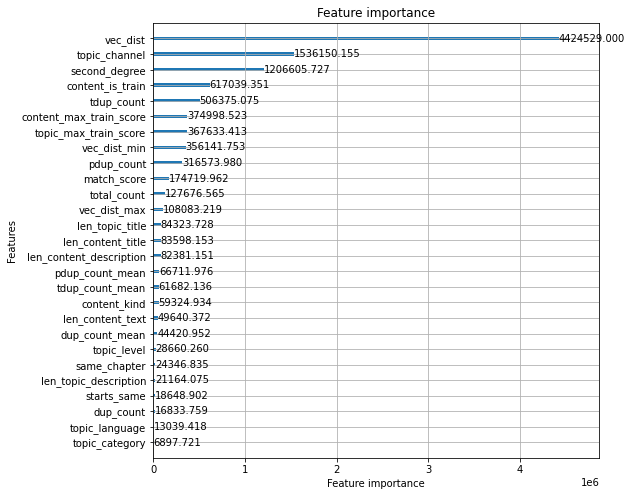

In [60]:
lgb.plot_importance(importance_type="gain", booster=model, figsize=(8, 8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

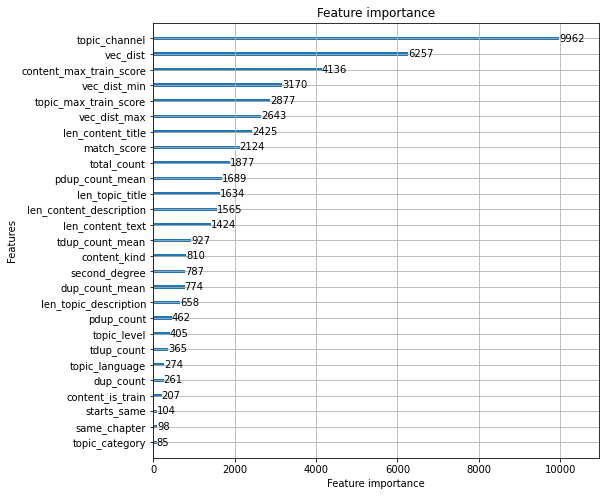

In [61]:
lgb.plot_importance(booster=model, figsize=(8, 8))

In [62]:
res_df["pred"] = y_oof

roc_auc_score(res_df["target"], res_df["pred"])

0.9924406776164021

In [63]:
#res_df.loc[~res_df["content_is_train"], "pred"] *= 0.0

In [98]:
res_df["rank"] = res_df.groupby("topic_id")["pred"].rank(method="first", ascending=False)

res_df["gap"] = res_df.groupby("topic_id")["pred"].transform("max") - res_df["pred"]

res_df["include_new_content"] = (res_df.groupby("content_id")["pred"].transform("max") == res_df["pred"]) & ~res_df["content_is_train"] & (res_df["pred"] > 0.5)

pred_df = res_df[(res_df["rank"] == 1) | ((res_df["gap"] < 0.25) & res_df["content_is_train"]) | res_df["include_new_content"]]

pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})

pred_df

,topic_id,pred
0,t_000d1fb3f2f5,c_b8d730238789 c_1ec97b588bce c_7868f655c31e c...
1,t_0016d30772f3,c_c25053d6fafd c_61b851222e17 c_061d9f90bb06 c...
2,t_001bcbb22694,c_1d9dfc709413
3,t_0020bde404c1,c_aa8f7f0cbeb3 c_085d324f601b c_978da5beda25 c...
4,t_00260f878951,c_86f126d7f1f8
...,...,...
8243,t_ffb0a70e5e48,c_f3b75faf5480 c_81f88e566297 c_f7c218334f49 c...
8244,t_ffb1d959761e,c_9b993553de45
8245,t_ffba5459a977,c_a46e0ec1377b c_04a421dba8aa c_787a7a2e7217 c...
8246,t_ffdc013937fc,c_2e959f78384e


In [99]:
pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")
pred_df.shape

(8248, 3)

In [100]:
metric(pred_df)

0.7584580402729476

In [101]:
x = res_df.groupby("topic_id")["target"].max()
ix = x[x == 0].index
len(ix), x.shape

(354, (8248,))

In [102]:
difficult_df = topic_df.set_index("topic_id").loc[ix].merge(corr_df, on="topic_id").merge(content_df, on="content_id")
difficult_df.shape

(1255, 34)

In [103]:
difficult_df.sample(5).T

,185,1174,302,961,604
topic_id,t_21c8907f5d3c,t_e39476f21e72,t_333dbc610978,t_a8c138ebcb5b,t_7ab6740c1f76
topic_title,Multiplication and Division,"Book: Dynamic Systems and Control (Dahleh, Dah...",Mode of Entry,Assessments,Combined operations
topic_description,NaN,"Book: Dynamic Systems and Control (Dahleh, Dah...",NaN,NaN,NaN
topic_channel,7db7f2,88c9d6,ef2088,274269,14cb7f
topic_category,supplemental,supplemental,supplemental,supplemental,supplemental
topic_level,2,3,5,5,3
topic_language,en,en,en,en,en
topic_parent,t_02359b8e34ca,t_0afed3a02007,t_dd07efe8d929,t_d04f36ad3ff0,t_aa6696bed369
topic_has_content,True,True,True,True,True
topic_parent_title,Mathematics,Industrial and Systems Engineering,International Business- 1,Operations on rational numbers,Operations


In [104]:
res_df[res_df["topic_id"] == "t_adf5741d6a79"].sort_values("vec_dist")[["content_t", "vec_dist", "pred", "content_id", "target", "content_kind"]].head(20)#.T

,content_t,vec_dist,pred,content_id,target,content_kind
72240,Organic Chemistry | html5 |,0.235658,0.993757,c_0c5af4baa365,0.0,html5
72241,Organic Chemistry Practice | exercise |,0.321481,0.979058,c_5b913fce12b7,0.0,exercise
72242,What Are Alcohols Organic Chemistry Chemistr...,0.572769,0.314961,c_c43bb1c60af9,0.0,video
72243,Organic Farming | video |,0.591377,0.518934,c_b65cdc45b048,0.0,video
72244,End of Unit 1 Introduction to Organic Chemistr...,0.599098,0.567072,c_458601acecea,0.0,exercise
72245,Organic Compounds | video |,0.613353,0.129833,c_f8cfe5c58d75,0.0,video
72246,Alkanes Alkenes Organic Chemistry Chemistry...,0.613506,0.078450,c_fcb0f55828c0,0.0,video
72247,Straight-Chain Alkanes | html5 |,0.624446,0.082838,c_1e640d849f1b,0.0,html5
72248,Pure and Applied Chemistry | html5 |,0.633823,0.186642,c_9e2105174dd6,0.0,html5
72249,Branched Alkanes | html5 |,0.638069,0.057254,c_36dfb7e7ddd6,0.0,html5


In [105]:
content_df[content_df["content_id"].isin({"c_d4cd86bb4256", "c_f9132f87dc46"})]

,content_id,content_title,content_description,content_kind,content_text,content_language,content_copyright_holder,content_license,content_t,content_chapter,content_is_train,content_label,content_max_train_score
128089,c_d4cd86bb4256,Fungi,,html5,NaN,en,NaN,NaN,Fungi | html5 |,NaN,True,"[14088, 22550]",0.165658
149895,c_f9132f87dc46,Fungi,,video,NaN,en,NaN,NaN,Fungi | video |,NaN,True,"[20204, 31637, 20430]",0.302923


In [106]:
le_topic.inverse_transform([15081, 22469])

array(['Hydrocarbons | ', 'Organic Chemistry | '], dtype=object)

In [107]:
x = corr_df.merge(topic_df_train, left_on="topic_id", right_on="id")[["t", "content_id"]].merge(content_df[content_df["content_is_train"]], on="content_id")

x = x[["t", "content_t"]]
x[x["t"].apply(lambda x: "Hydrocarbons" in x)]

,t,content_t
1993,Alkenes: Properties @ Hydrocarbons @ Chemistry...,Addition of water (acid-catalyzed) mechanism |...
1995,Alkenes: Properties @ Hydrocarbons @ Chemistry...,Markovnikov's rule and carbocations | video | ...
1997,Alkenes: Properties @ Hydrocarbons @ Chemistry...,Ozonolysis | video | Alkene cleavage using ozo...
1998,Alkene reactions @ Hydrocarbons (5) @ Form 4 C...,Ozonolysis | video | Alkene cleavage using ozo...
2000,Alkenes: Properties @ Hydrocarbons @ Chemistry...,Introduction to reaction mechanisms | video | ...
...,...,...
195211,Cyclic Hydrocarbons @ Carbon and its Compounds...,Cyclic Hydrocarbons | video |
208168,Unsaturated Hydrocarbons @ Organic Chemistry @...,Alkenes - Example 1 | video |
218706,Unsaturated Hydrocarbons @ Organic Chemistry @...,Unsaturated Hydrocarbons Practice | exercise |
234760,Saturated Hydrocarbons @ Organic Chemistry @ P...,Saturated Hydrocarbons Practice | exercise |


In [108]:
x[x["t"].apply(lambda x: "Hydrocarbons" in x)].sample(5).values

array([['Alkanes: Conformations @ Hydrocarbons @ Chemistry class 11 @ Science (India) | ',
        'Conformational analysis of ethane | video | How to analyze the staggered and eclipsed conformations of ethane\n\n'],
       ['Alkene reactions @ Hydrocarbons (5) @ Form 4 Chemistry @ Chemistry | In this tutorial, Jay explains the addition reactions of alkenes.',
        "Syn dihydroxylation | video | Reactions that add two hydroxyls to the same face of an alkene double bond as\nit's converted to a single bond.\n\n"],
       ['Alkene reactions @ Hydrocarbons (5) @ Form 4 Chemistry @ Chemistry | In this tutorial, Jay explains the addition reactions of alkenes.',
        'Alkanes  Alkenes  Organic Chemistry  Chemistry  FuseSchool | video | '],
       ['Properties of benzene @ Hydrocarbons @ Chemistry class 11 @ Science (India) | ',
        'Friedel-Crafts acylation | video | Friedel-Crafts acylation reaction.\n\n'],
       ['Directive influence of a functional group in a mono substituted be

In [109]:
np.save("cache/V_content.npy", V_content)
np.save("cache/V_topic.npy", V_topic)
np.save("cache/V_topic_train.npy", V_topic_train)

In [110]:
res_df["rank"] = res_df.groupby("topic_id")["vec_dist"].rank(method="first", ascending=True)

res_df["gap"] = res_df["vec_dist"] - res_df.groupby("topic_id")["vec_dist"].transform("min")

pred_df = res_df[res_df["gap"] < 0.15]

pred_df = pred_df.groupby("topic_id")["content_id"].apply(lambda x: " ".join(list(x)))
pred_df = pred_df.reset_index().rename(columns={"content_id": 'pred'})

pred_df = pred_df.merge(pd.read_csv("data/correlations.csv"), on="topic_id")

metric(pred_df)

0.695352258637265